<a href="https://colab.research.google.com/github/NanaAkwasiAbayieBoateng/Machine-Learning-Interpretability/blob/master/InterpretabilitywithR3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Introduction
---------------------------------
The two main packages in R for machine learning interpretability is the iml and DALEX. H2o package also has built in functions to perform some interpretability such as partial dependence plots. DALEX and iml are model agnostic as such can be used to explain several supervised machine learning models including xgboost,random forest, support vector machines, deep learning(keras and h2o MLP).The  shapper library  Implements a wrapper for the Python shap library that provides SHapley Additive exPlanations (SHAP).

Before we proceed, there are a few preprocessing steps that is used to load data from a python evironment which is then converted to an R dataframe  using rpy2 package and magic functions. This post follows an earlier post on machine learning interpretability in python.

In [0]:
# activate R magic
import rpy2
%load_ext rpy2.ipython

In [0]:
%%capture  #hide cell output
%%R
install.packages("pacman")

In [0]:
import numpy as np
import pandas as pd
from google.colab import files
import io

#### Loading Data

[link to data](https://archive.ics.uci.edu/ml/datasets/Heart+Disease)
This database contains 76 attributes, but all published experiments refer to using a subset of 14 of them. In particular, the Cleveland database is the only one that has been used by ML researchers to this date. The "goal" field refers to the presence of heart disease in the patient. It is integer valued from 0 (no presence) to 4.

Content

Attribute Information: 
Only 14 attributes used: 
1. age: age in years
2. sex: sex (1 = male; 0 = female) 
3. cp: chest pain type 
        -- Value 1: typical angina 
        -- Value 2: atypical angina 
        -- Value 3: non-anginal pain 
        -- Value 4: asymptomatic  
4. trestbps: resting blood pressure (in mm Hg on admission to the hospital)  
5. chol: serum cholestoral in mg/dl
6. fbs: (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false) 
7. restecg: resting electrocardiographic results 
            -- Value 0: normal 
            -- Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or                  depression of > 0.05 mV) 
        -- Value 2: showing probable or definite left ventricular hypertrophy by Estes'                    criteria  
8. thalach: maximum heart rate achieved  
9. exang: exercise induced angina (1 = yes; 0 = no)
10. oldpeak = ST depression induced by exercise relative to rest  
11. slope: the slope of the peak exercise ST segment 
           -- Value 1: upsloping 
            -- Value 2: flat 
            -- Value 3: downsloping  
12. ca: number of major vessels (0-3) colored by flourosopy  
13.  thal: 3 = normal; 6 = fixed defect; 7 = reversable defect 
14. target: diagnosis of heart disease (angiographic disease status) 
-- Value 0: < 50% diameter narrowing 
-- Value 1: > 50% diameter narrowing 
(in any major vessel: attributes 59 through 68 are vessels) 



In [0]:
#uploaded = files.upload()

In [0]:
#for fn in uploaded.keys():
#  print('User uploaded file "{name}" with length {length} bytes'.format(
#      name=fn, length=len(uploaded[fn])))

In [4]:
heart_data=pd.read_csv('https://raw.githubusercontent.com/NanaAkwasiAbayieBoateng/Datasets/master/heart.csv')
heart_data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [0]:
#heart_data=pd.read_csv(io.StringIO(uploaded['heart.csv'].decode('utf-8')))
#heart_data.head()

Load Required Packages
---------------------------------

The pacman package provides a convenient way to load packages. It installs the package before loading if it not already installed.One of my favorite themes that I use with ggplot is the theme_pubclean. Here I set all themes with ggplot by it.

In [0]:
%%capture
%%R
pacman::p_load(tidyverse,h2o,iml,Hmisc)

pacman::p_load(tidyverse,reticulate,DataExplorer,skimr,ggpubr,viridis,
               kableExtra,caret,recipes,rsample,yardstick,pROC,
               xgboost,mlr,readxl,stringr,VIM,
               MLmetrics,data.table,furrr,ALEPlot,pdp,iBreakDown)
    
    
#Load  variable importance plot
source("https://raw.githubusercontent.com/NanaAkwasiAbayieBoateng/MLTools/master/Varplot.R")

source("https://raw.githubusercontent.com/NanaAkwasiAbayieBoateng/MLTools/master/EvaluationMetrics.R")


theme_set(theme_pubclean())
    

In [0]:
%%capture
%%R
if (!require("forcats")) {
    install.packages("forcats")
}

pacman::p_load(lime,DALEX,forcats,ALEPlot,pdp,iBreakDown,localModel,breakDown,
              xfun,clipr,clipr,sf,spdep)
# dependencies

#devtools::install_github("pbiecek/breakDown")

# DALEX package
#devtools::install_github("pbiecek/DALEX")
#devtools::install_github("MI2DataLab/factorMerger")    

#install.packages("factorMerger")
#install.packages(c("devtools","DALEX","units"))
pacman::p_load(agricolae,factorMerger)
pacman::p_load(units)
#devtools::install_github("ModelOriented/shapper")

#pacman::p_load("clipr","ggplot2","rlang","xfun","agricolae","clipr","sf","spdep","breakDown",localModel)

Start h2o cluster here!

In [99]:
%%R
localH2O = h2o.init()
h2o.no_progress()


H2O is not running yet, starting it now...

Note:  In case of errors look at the following log files:
    /tmp/RtmpAMmTUN/h2o_UnknownUser_started_from_r.out
    /tmp/RtmpAMmTUN/h2o_UnknownUser_started_from_r.err


Starting H2O JVM and connecting: . Connection successful!

R is connected to the H2O cluster: 
    H2O cluster uptime:         1 seconds 925 milliseconds 
    H2O cluster timezone:       Etc/UTC 
    H2O data parsing timezone:  UTC 
    H2O cluster version:        3.24.0.5 
    H2O cluster version age:    10 days  
    H2O cluster name:           H2O_started_from_R_root_zsc832 
    H2O cluster total nodes:    1 
    H2O cluster total memory:   2.94 GB 
    H2O cluster total cores:    2 
    H2O cluster allowed cores:  2 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          localhost 
    H2O Connection port:        54321 
    H2O Connection proxy:       NA 
    H2O Internal Security:      FALSE 
    H2O API Extensions:         Amazon S3, XGBoost, Algos, Auto

In [8]:
from rpy2.robjects import pandas2ri
pandas2ri.activate()
Rheart_data = pandas2ri.py2ri(heart_data)
type(Rheart_data)

rpy2.robjects.vectors.DataFrame

#### Convert Python Dataframe to R dataframe

The  python dataframe  can be converted to an R dataframe.

In [100]:
%%R -i heart_data

head(heart_data,5)

/usr/local/lib/python3.6/dist-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


  age sex cp trestbps chol fbs restecg thalach exang oldpeak slope ca thal
0  63   1  3      145  233   1       0     150     0     2.3     0  0    1
1  37   1  2      130  250   0       1     187     0     3.5     0  0    2
2  41   0  1      130  204   0       0     172     0     1.4     2  0    2
3  56   1  1      120  236   0       1     178     0     0.8     2  0    2
4  57   0  0      120  354   0       1     163     1     0.6     2  0    2
  target
0      1
1      1
2      1
3      1
4      1


In [11]:
%%R 
str(heart_data)

glimpse(heart_data)

'data.frame':	303 obs. of  14 variables:
 $ age     : int  63 37 41 56 57 57 56 44 52 57 ...
 $ sex     : int  1 1 0 1 0 1 0 1 1 1 ...
 $ cp      : int  3 2 1 1 0 0 1 1 2 2 ...
 $ trestbps: int  145 130 130 120 120 140 140 120 172 150 ...
 $ chol    : int  233 250 204 236 354 192 294 263 199 168 ...
 $ fbs     : int  1 0 0 0 0 0 0 0 1 0 ...
 $ restecg : int  0 1 0 1 1 1 0 1 1 1 ...
 $ thalach : int  150 187 172 178 163 148 153 173 162 174 ...
 $ exang   : int  0 0 0 0 1 0 0 0 0 0 ...
 $ oldpeak : num  2.3 3.5 1.4 0.8 0.6 0.4 1.3 0 0.5 1.6 ...
 $ slope   : int  0 0 2 2 2 1 1 2 2 2 ...
 $ ca      : int  0 0 0 0 0 0 0 0 0 0 ...
 $ thal    : int  1 2 2 2 2 1 2 3 3 2 ...
 $ target  : int  1 1 1 1 1 1 1 1 1 1 ...
Observations: 303
Variables: 14
$ age      <int> 63, 37, 41, 56, 57, 57, 56, 44, 52, 57, 54, 48, 49, 64, 58, …
$ sex      <int> 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, …
$ cp       <int> 3, 2, 1, 1, 0, 0, 1, 1, 2, 2, 0, 2, 1, 3, 3, 2, 2, 3, 0, 3, …
$ trestbps <in

In [16]:
%%R
summarizeColumns(heart_data)

       name    type na        mean       disp median      mad min   max nlevs
1       age integer  0  54.3663366  9.0821010   55.0 10.37820  29  77.0     0
2       sex integer  0   0.6831683  0.4660108    1.0  0.00000   0   1.0     0
3        cp integer  0   0.9669967  1.0320525    1.0  1.48260   0   3.0     0
4  trestbps integer  0 131.6237624 17.5381428  130.0 14.82600  94 200.0     0
5      chol integer  0 246.2640264 51.8307510  240.0 47.44320 126 564.0     0
6       fbs integer  0   0.1485149  0.3561979    0.0  0.00000   0   1.0     0
7   restecg integer  0   0.5280528  0.5258596    1.0  0.00000   0   2.0     0
8   thalach integer  0 149.6468647 22.9051611  153.0 22.23900  71 202.0     0
9     exang integer  0   0.3267327  0.4697945    0.0  0.00000   0   1.0     0
10  oldpeak numeric  0   1.0396040  1.1610750    0.8  1.18608   0   6.2     0
11    slope integer  0   1.3993399  0.6162261    1.0  1.48260   0   2.0     0
12       ca integer  0   0.7293729  1.0226064    0.0  0.00000   


There are no issues with missing data. The data is complete.



 Variables sorted by number of missings: 
 Variable Count
      age     0
      sex     0
       cp     0
 trestbps     0
     chol     0
      fbs     0
  restecg     0
  thalach     0
    exang     0
  oldpeak     0
    slope     0
       ca     0
     thal     0
   target     0


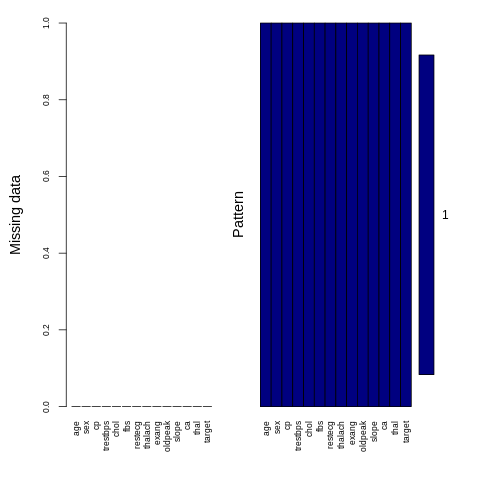

In [17]:
%%R
aggr(heart_data , col=c('navyblue','yellow'),
                    numbers=TRUE, sortVars=TRUE,
                    labels=names(heart_data), cex.axis=.7,
                    gap=3, ylab=c("Missing data","Pattern"))

The variable thalach has moderate correlation with the age variable. There are no significant 
correlations between the other variables.

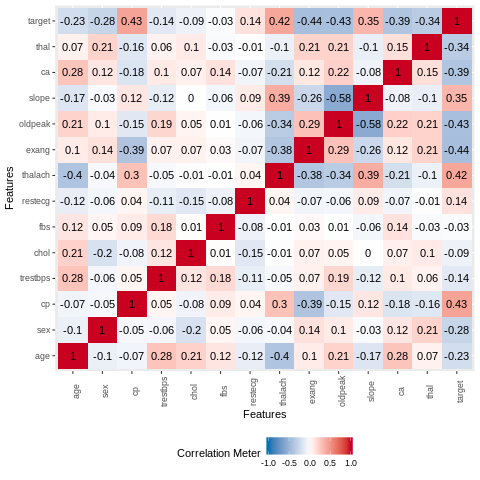

In [18]:
%%R
plot_correlation(heart_data,type = "continuous",theme_config = list(legend.position = "bottom", axis.text.x =
  element_text(angle = 90)))


Another way to obatin the summary  statistics for each variable in the data is with the skim_to_wide function from the sikmr package.

In [19]:
%%R

skimmed <-skim_to_wide(heart_data)
skimmed
  #kable() 
 # kable_styling()

# A tibble: 14 x 13
   type  variable missing complete n     mean  sd    p0    p25   p50   p75  
   <chr> <chr>    <chr>   <chr>    <chr> <chr> <chr> <chr> <chr> <chr> <chr>
 1 inte… age      0       303      303   " 54… " 9.… 29    " 47… 55    " 61…
 2 inte… ca       0       303      303   "  0… " 1.… 0     "  0… 0     "  1…
 3 inte… chol     0       303      303   246.… 51.83 126   "211… 240   274.5
 4 inte… cp       0       303      303   "  0… " 1.… 0     "  0… 1     "  2…
 5 inte… exang    0       303      303   "  0… " 0.… 0     "  0… 0     "  1…
 6 inte… fbs      0       303      303   "  0… " 0.… 0     "  0… 0     "  0…
 7 inte… restecg  0       303      303   "  0… " 0.… 0     "  0… 1     "  1…
 8 inte… sex      0       303      303   "  0… " 0.… 0     "  0… 1     "  1…
 9 inte… slope    0       303      303   "  1… " 0.… 0     "  1… 1     "  2…
10 inte… target   0       303      303   "  0… " 0.… 0     "  0… 1     "  1…
11 inte… thal     0       303      303   "  2… " 0.… 0  

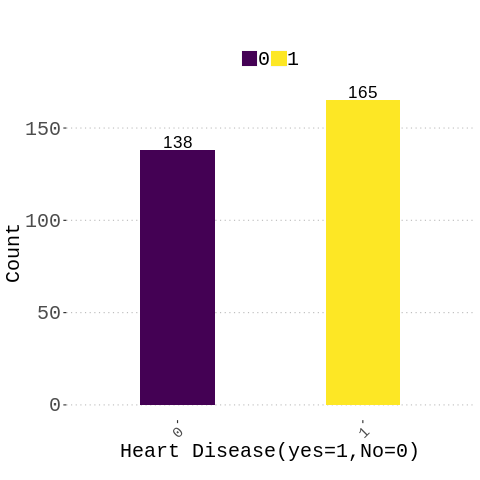

In [20]:
%%R

heart_data%>%mutate(target=as_factor(target))%>%group_by(target)%>%
summarise(n=n())%>%
    ggplot(aes(y= n,x=reorder(target,n),fill=target))+

geom_bar(stat="identity",position = position_dodge(width = 0.8),width = 0.4)+
  
  scale_fill_viridis(discrete = T, option = "D")+
   theme(
    # no legend 
    #legend.position="none",
    plot.caption=element_text(hjust=0,size = 8),
    legend.direction="horizontal",
   
    legend.title = element_blank(),
    text=element_text(size=20,  family="Comic Sans MS"),
   
    legend.text = element_text(size = 20),# legend title size
    
    plot.title = element_text(hjust = 0.5,size = 16), #position legend in the middle
    plot.subtitle = element_text(hjust = 0.5,colour = "red",size = 12),
    axis.text.x = element_text(angle = 45, hjust = 1,size = 15),
    axis.text.y = element_text(size = 20))+
  labs(x="Heart Disease(yes=1,No=0)",y="Count",
       title=" ",
         subtitle=paste0(""),
         caption="" )+
  
  #theme(aspect.ratio = 0.2/0.1)+

geom_text(aes(label=round(n,2),vjust=-0.2),color="black",size = 6)+
  scale_y_continuous(labels = scales::number)
    #geom_text(aes(label=c(1,2),vjust=0.1),position = position_dodge(width = 1),color="black",size=5)
#glue(" RMSE: {round(rmse_val_gbm, digits = 2)}")

In [21]:
%%R
#check classes distribution
prop.table(table(heart_data$target))*100


       0        1 
45.54455 54.45545 


Model Building
---------------------------------

The rsample package can be used to split the data into training and test set. Two models will be built , the elastic net logistic regression and Automatic machine learning. These models will be interpretated afterwards. Our goal is to predict predict the probability of developing a heart disease based  on features such as age, sex ,cholesterol levels etc.

In [0]:
%%R

library(rsample)



var<-Hmisc::Cs(target, sex,cp,fbs,restecg,exang,slope,thal,ca)



heart_data<-heart_data%>%mutate_at(var, as_factor)




data_split <- initial_split(heart_data, strata = "target", prop = 0.75)

heartdata_train <- training(data_split)
heartdata_test  <- testing(data_split)

In [102]:
%%R

heartdata_recipe <- recipe(target ~ ., data = heartdata_train ) %>%
  #Transform numeric skewed predictors
  #step_YeoJohnson(all_numeric()) %>%
  # standardize the data 
  #step_center(all_numeric(), -all_outcomes()) %>%
  #scale the data
  #step_scale(all_numeric(), -all_outcomes()) %>%
  #step_kpca a specification of a recipe step that will convert numeric data into one or more principal components using a kernel basis expansion.
  #step_kpca(all_numeric(), num=6)%>%
  #step_log(Label, base = 10)
  # Lump factor levels that occur in <= 10% of data as "other"
  #step_other(Factor_E , Factor_C , threshold = 0.1) %>%
  # Create dummy variables for all nominal predictor factor variables except the response
  #step_dummy(all_nominal(), -all_outcomes())%>%
  prep(data = heartdata_train,retain = TRUE )

# split data into training and test set
test_tbl  <- bake(heartdata_recipe, newdata = heartdata_test)
train_tbl <- bake(heartdata_recipe, newdata = heartdata_train) 
glimpse(test_tbl)

Observations: 75
Variables: 14
$ age      <int> 57, 64, 58, 50, 44, 54, 46, 54, 51, 48, 53, 66, 45, 71, 58, …
$ sex      <fct> 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, …
$ cp       <fct> 0, 3, 3, 2, 1, 2, 2, 2, 2, 1, 0, 0, 0, 2, 2, 1, 2, 1, 2, 3, …
$ trestbps <int> 140, 110, 150, 120, 130, 125, 142, 150, 140, 130, 130, 120, …
$ chol     <int> 192, 211, 283, 219, 219, 273, 177, 232, 308, 245, 264, 302, …
$ fbs      <fct> 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, …
$ restecg  <fct> 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, …
$ thalach  <int> 148, 144, 162, 158, 188, 152, 160, 165, 142, 180, 143, 151, …
$ exang    <fct> 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, …
$ oldpeak  <dbl> 0.4, 1.8, 1.0, 1.6, 0.0, 0.5, 1.4, 1.6, 1.5, 0.2, 0.4, 0.4, …
$ slope    <fct> 1, 1, 2, 1, 2, 0, 0, 2, 2, 1, 1, 1, 2, 2, 2, 1, 2, 2, 2, 1, …
$ ca       <fct> 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, …
$ thal     <fct> 1, 2

In [0]:
%%R

test=as.h2o(test_tbl)

train=as.h2o(train_tbl)


outcome_name <- "target" #response column: digits 0-1
features <- setdiff(colnames(train), outcome_name)


# try using the `categorical_encoding` parameter:
#encoding = "OneHotExplicit"



Autimatic machine learning. h2o has built in functions to handle categorical variables.

In [0]:
%%R

model_h2o_automl <- h2o.automl(x = features, y = outcome_name,
                  training_frame = train,
                  leaderboard_frame = test,
                  #categorical_encoding = encoding,
                  #max_models = 10,
                  max_runtime_secs = 360)

Elastic net logistic regression

In [0]:
%%R
# elastic net model 
model_h2o_glm <- h2o.glm(
  x = features, 
  y = outcome_name, 
  training_frame = train,
  #categorical_encoding = encoding,  
  #validation_frame = splits$valid,
  family = "binomial",
  seed = 123
  )

Gradient boosting machines

In [0]:

%%R
# elastic net model 
model_h2o_gbm <- h2o.gbm(
  x = features, 
  y = outcome_name, 
  training_frame = train,
  seed = 123
  )

We  can see the performance of the varoius models trained by AutoML as below.

In [107]:
%%R

model_h2o_automl@leaderboard%>%as_tibble()

# A tibble: 56 x 6
   model_id                           auc logloss mean_per_class_er…  rmse   mse
   <chr>                            <dbl>   <dbl>              <dbl> <dbl> <dbl>
 1 GBM_grid_1_AutoML_20190629_2352… 0.902   0.397              0.137 0.349 0.122
 2 XRT_1_AutoML_20190629_235225     0.902   0.402              0.152 0.363 0.132
 3 GBM_4_AutoML_20190629_235225     0.898   0.400              0.149 0.354 0.125
 4 GBM_grid_1_AutoML_20190629_2352… 0.898   0.405              0.125 0.356 0.126
 5 GBM_grid_1_AutoML_20190629_2352… 0.892   0.530              0.152 0.414 0.171
 6 GBM_1_AutoML_20190629_235225     0.892   0.452              0.161 0.373 0.139
 7 GBM_grid_1_AutoML_20190629_2352… 0.892   0.413              0.171 0.367 0.135
 8 GBM_grid_1_AutoML_20190629_2352… 0.891   0.430              0.184 0.375 0.141
 9 DeepLearning_grid_1_AutoML_2019… 0.890   0.998              0.154 0.431 0.186
10 GBM_2_AutoML_20190629_235225     0.890   0.429              0.169 0.368 0.135
# … with 

In [108]:
%%R

# Get model ids for all models in the AutoML Leaderboard
model_ids <- as.data.frame(model_h2o_automl@leaderboard$model_id)[,1]
# Get the "All Models" Stacked Ensemble model
se <- h2o.getModel(grep("StackedEnsemble_AllModels", model_ids, value = TRUE)[1])
# Get the Stacked Ensemble metalearner model
metalearner <- h2o.getModel(se@model$metalearner$name)
metalearner

Model Details:

H2OBinomialModel: glm
Model ID:  metalearner_AUTO_StackedEnsemble_AllModels_AutoML_20190629_235225 
GLM Model: summary
    family  link                               regularization
1 binomial logit Elastic Net (alpha = 0.5, lambda = 0.07518 )
  number_of_predictors_total number_of_active_predictors number_of_iterations
1                         54                          17                    4
                                                      training_frame
1 levelone_training_StackedEnsemble_AllModels_AutoML_20190629_235225

Coefficients: glm coefficients
                                       names coefficients
1                                  Intercept    -5.679779
2 GBM_grid_1_AutoML_20190629_235225_model_18     0.000000
3               XRT_1_AutoML_20190629_235225     0.000000
4               GBM_4_AutoML_20190629_235225     0.000000
5  GBM_grid_1_AutoML_20190629_235225_model_6     0.000000
  standardized_coefficients
1                  0.219734
2          

In [109]:
%%R

h2o.performance(model = model_h2o_automl@leader,
                            newdata = test)

H2OBinomialMetrics: gbm

MSE:  0.1215225
RMSE:  0.3486007
LogLoss:  0.3968175
Mean Per-Class Error:  0.1370158
AUC:  0.902439
pr_auc:  0.8841764
Gini:  0.804878

Confusion Matrix (vertical: actual; across: predicted) for F1-optimal threshold:
        0  1    Error    Rate
0      28  6 0.176471   =6/34
1       4 37 0.097561   =4/41
Totals 32 43 0.133333  =10/75

Maximum Metrics: Maximum metrics at their respective thresholds
                        metric threshold    value idx
1                       max f1  0.425192 0.880952  42
2                       max f2  0.374540 0.919811  47
3                 max f0point5  0.425192 0.868545  42
4                 max accuracy  0.425192 0.866667  42
5                max precision  0.986887 1.000000   0
6                   max recall  0.066036 1.000000  65
7              max specificity  0.986887 1.000000   0
8             max absolute_mcc  0.425192 0.730701  42
9   max min_per_class_accuracy  0.660464 0.829268  38
10 max mean_per_class_accuracy  

In [110]:
%%R

h2o.performance(model = model_h2o_glm,
                            newdata = test)

H2OBinomialMetrics: glm

MSE:  0.1453689
RMSE:  0.3812727
LogLoss:  0.4509688
Mean Per-Class Error:  0.1861549
AUC:  0.8708752
pr_auc:  0.8678079
Gini:  0.7417504
R^2:  0.4134147
Residual Deviance:  67.64533
AIC:  99.64533

Confusion Matrix (vertical: actual; across: predicted) for F1-optimal threshold:
        0  1    Error    Rate
0      23 11 0.323529  =11/34
1       2 39 0.048780   =2/41
Totals 25 50 0.173333  =13/75

Maximum Metrics: Maximum metrics at their respective thresholds
                        metric threshold    value idx
1                       max f1  0.484152 0.857143  49
2                       max f2  0.484152 0.911215  49
3                 max f0point5  0.515854 0.822222  45
4                 max accuracy  0.515854 0.826667  45
5                max precision  0.943599 1.000000   0
6                   max recall  0.116149 1.000000  68
7              max specificity  0.943599 1.000000   0
8             max absolute_mcc  0.484152 0.662860  49
9   max min_per_class_ac

In [111]:
%%R

h2o.confusionMatrix(model_h2o_automl@leader,newdata = test)

Confusion Matrix (vertical: actual; across: predicted)  for max f1 @ threshold = 0.425191689155488:
        0  1    Error    Rate
0      28  6 0.176471   =6/34
1       4 37 0.097561   =4/41
Totals 32 43 0.133333  =10/75


In [112]:
%%R
# If you need to generate predictions on a test set, you can make
# predictions directly on the `"H2OAutoML"` object, or on the leader
# model object directly


predictions <- h2o.predict(object = model_h2o_automl@leader, newdata = test)

head(predictions)

  predict         p0        p1
1       0 0.62546017 0.3745398
2       0 0.57480831 0.4251917
3       1 0.07417565 0.9258244
4       1 0.03825505 0.9617449
5       1 0.02999795 0.9700020
6       0 0.31848066 0.6815193


In [38]:
%%R

p_function <- function(model, data) {
    

p=predict(model,data)[,-1]  
    
prob=apply(p,1,max)    
    
return(prob)    
}

#predict(model, newdata = data, type = "prob")

#p_function(model_h2o_automl@leader,test)



p_function(model_h2o_automl@leader,test)

  |======================================================================| 100%
         C1
1 0.9569291
2 0.9993939
3 0.9974936
4 0.9958008
5 0.6880486
6 0.8747901

[75 rows x 1 column] 


In [39]:
%%R

h2o::h2o.head(predictions$predict)    

  predict
1       1
2       1
3       1
4       1
5       0
6       1


Feature interpretation {#glm-h2o-classification-binary-viz}
Feature importance
To identify the most influential variables we can use h2o's variable importance plot. Variable importance is simply represented by the standardized coefficients. We see that response and Factor_D have the largest influence in increasing the probability of Approval whereas Factor_E.B and Factor_E.C. No have the largest influence in decreasing the probability of attrition.

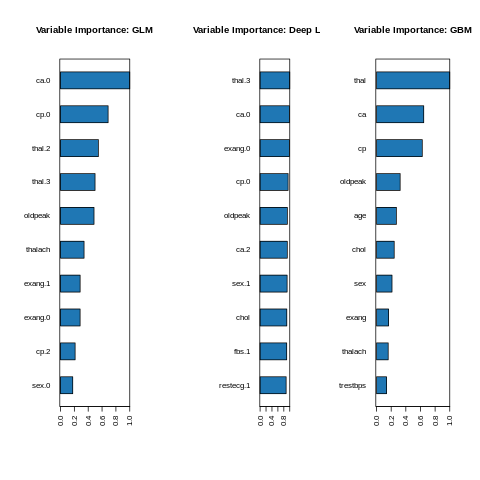

In [43]:
%%R
par(mfrow=c(1,3))

h2o::h2o.varimp_plot(model_h2o_glm)
box()    
#p2<-h2o.varimp_plot(aml@leader, num_of_features = 12)
h2o.varimp_plot(model_h2o_automl@leader)
box()


h2o.varimp_plot(model_h2o_gbm)
box()
#Varplot(feature=h2o_autodata$names,Importance=h2o_autodata$coefficients)
#gridExtra::grid.arrange(p1, nrow = 1)

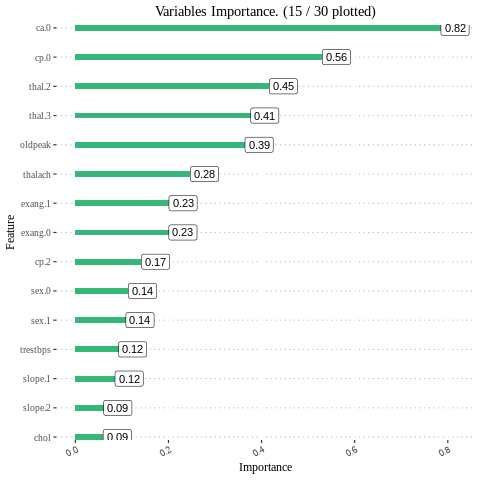

In [47]:
%%R

h2o_glmdata<-data.frame(h2o.varimp(model_h2o_glm))

#h2o_glmdata

Varplot(feature=h2o_glmdata$variable,Importance=h2o_glmdata$relative_importance)



In [48]:
%%R


paste('accuracy :',mean(test$target==predictions$predict))



#class(predictions$predict%>%as_tibble())

[1] "accuracy : 0.893333333333333"


In [49]:
%%R

#as.data.frame(predictions)[[3L]]
head(predictions)

  predict           p0        p1
1       1 0.0430708770 0.9569291
2       1 0.0006061397 0.9993939
3       1 0.0025064191 0.9974936
4       1 0.0041991558 0.9958008
5       0 0.3119513854 0.6880486
6       1 0.1252098803 0.8747901


IML PROCEDURES
-------------------------------------------------------------------------

Steps to using iml:

* Create a data frame with just the features (must be of class data.frame, cannot be an H2OFrame or other class).*

* Create a vector with the actual responses (must be numeric - 0/1 for binary classification problems).*

* iml has internal support for some machine learning packages (i.e. mlr, caret, randomForest). However, to use iml with several of the more popular packages being used today (i.e. h2o, ranger, xgboost) we need to create a custom function that will take a data set (again must be of class data.frame) and provide the predicted values as a vector.*


Create a predictor function for iml

In [81]:
%%R
h2o.no_progress()
# 1. create a data frame with just the features
features <- test_tbl %>% select(-target)

# 2. Create a vector with the actual responses
response <- as.numeric(test_tbl$target)

# 3. Create custom predict function that returns the predicted values as a
#    vector (probability of purchasing in our example)
pred  <- function(model, newdata)  {
  results <- as.data.frame(h2o.predict(model, as.h2o(newdata)))
  return(results[[3L]])
}

# example of prediction output
pred (model_h2o_automl@leader, features) %>% head()

[1] 0.9569291 0.9993939 0.9974936 0.9958008 0.6880486 0.8747901


Create an explainer function

In [0]:
%%R
predictor.AutoML <- Predictor$new(
  model = model_h2o_automl, 
  data = features, 
  y = response, 
  predict.fun = pred,
  class = "classification"
  )


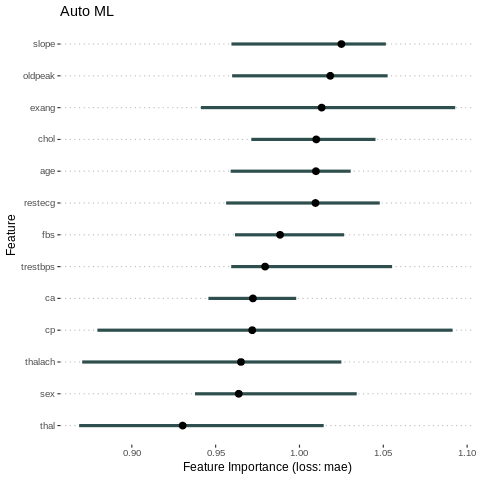

In [82]:
%%R

# compute feature importance with specified loss metric
#imp.AutoML <- FeatureImp$new(predictor.AutoML, loss = "mse")
imp = FeatureImp$new(predictor.AutoML, loss = "mae")
plot(imp)+ ggtitle("Auto ML")

# plot output
#plot(imp.AutoML) + ggtitle("Auto ML")


#gridExtra::grid.arrange(p1, p2, p3, nrow = 1)

#### Partial Dependence Plot
Partial Dependence Plots (PDP) are one of the most popular methods for exploration of the relation between a continuous variable and the model outcome.

Function variable_response() with the parameter type = "pdp" calls pdp::partial() function to calculate PDP response.

In [90]:
%%R

p1<-Partial$new(predictor.AutoML, "ca") %>% plot() + ggtitle("Auto ML")


p2<-Partial$new(predictor.AutoML, "cp") %>% plot() + ggtitle("Auto ML")




gridExtra::grid.arrange(p1, p2, nrow = 2)


ERROR: Unexpected HTTP Status code: 404 Not Found (url = http://localhost:54321/4/Predictions/models/DeepLearning_grid_1_AutoML_20190629_175502_model_2/frames/newdata_sid_937a_959)

water.exceptions.H2OKeyNotFoundArgumentException
 [1] "water.exceptions.H2OKeyNotFoundArgumentException: Object 'DeepLearning_grid_1_AutoML_20190629_175502_model_2' not found in function: predict for argument: model"
 [2] "    water.api.ModelMetricsHandler.predictAsync(ModelMetricsHandler.java:346)"                                                                                    
 [3] "    java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)"                                                                              
 [4] "    java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)"                                                            
 [5] "    java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAcc

In [91]:
%%R



p3<-Partial$new(predictor.AutoML, "thalach") %>% plot() + ggtitle("Auto ML")


p4<-Partial$new(predictor.AutoML, "age") %>% plot() + ggtitle("Auto ML")



gridExtra::grid.arrange(p3,p4, nrow = 2)


ERROR: Unexpected HTTP Status code: 404 Not Found (url = http://localhost:54321/4/Predictions/models/DeepLearning_grid_1_AutoML_20190629_175502_model_2/frames/newdata_sid_937a_961)

water.exceptions.H2OKeyNotFoundArgumentException
 [1] "water.exceptions.H2OKeyNotFoundArgumentException: Object 'DeepLearning_grid_1_AutoML_20190629_175502_model_2' not found in function: predict for argument: model"
 [2] "    water.api.ModelMetricsHandler.predictAsync(ModelMetricsHandler.java:346)"                                                                                    
 [3] "    java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)"                                                                              
 [4] "    java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)"                                                            
 [5] "    java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAcc

  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%


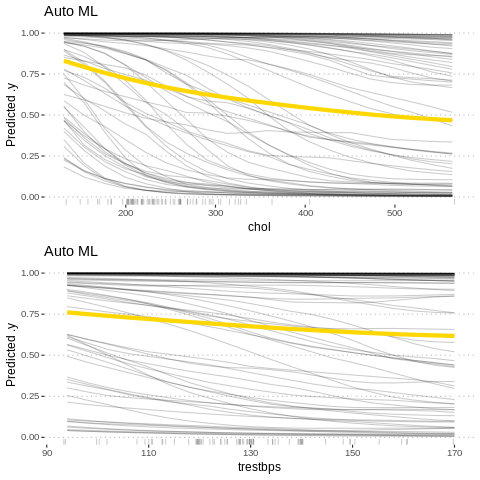

In [55]:
%%R



p5<-Partial$new(predictor.AutoML, "chol") %>% plot() + ggtitle("Auto ML")

p6<-Partial$new(predictor.AutoML, "trestbps") %>% plot() + ggtitle("Auto ML")

gridExtra::grid.arrange(p5,p6, nrow = 2)
    

   

#### Feature effects
Besides knowing which features were important, we are interested in how the features influence the predicted outcome. The FeatureEffect class implements accumulated local effect plots, partial dependence plots and individual conditional expectation curves. The following plot shows the accumulated local effects (ALE) for the feature ‘lstat’. ALE shows how the prediction changes locally, when the feature is varied. The marks on the x-axis indicates the distribution of the ‘lstat’ feature, showing how relevant a region is for interpretation (little or no points mean that we should not over-interpret this region).

  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%


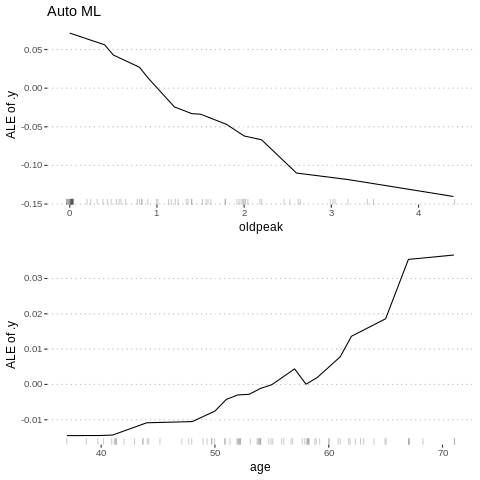

In [56]:
%%R

c1= FeatureEffect$new(predictor.AutoML, feature =c("age"))


c2 = FeatureEffect$new(predictor.AutoML, feature = "oldpeak")




gridExtra::grid.arrange(c2$plot()+ ggtitle("Auto ML"), c1$plot(),nrow = 2)

  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%


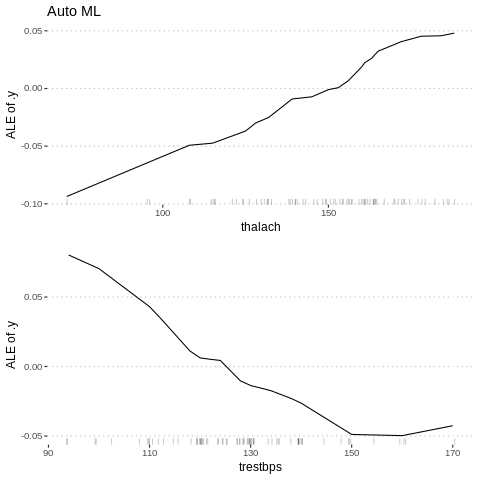

In [57]:
%%R



c3<-FeatureEffect$new(predictor.AutoML, "thalach")


c4<-FeatureEffect$new(predictor.AutoML, "trestbps") 


gridExtra::grid.arrange(c3$plot()+ ggtitle("Auto ML"),
                        c4$plot(),nrow = 2)


  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%


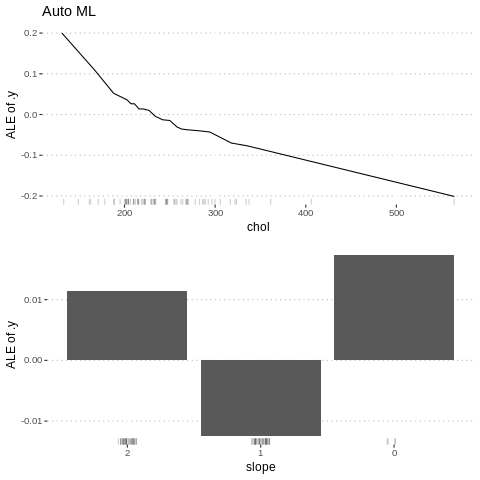

In [58]:
%%R


c5<-FeatureEffect$new(predictor.AutoML, "chol")


c6<-FeatureEffect$new(predictor.AutoML, "slope")


gridExtra::grid.arrange(c5$plot()+ ggtitle("Auto ML"), c6$plot(),nrow = 2)

/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Loading required package: glmnet

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Loading required package: Matrix

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 
Attaching package: ‘Matrix’


  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: The following object is masked from ‘package:tidyr’:

    expand


  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Loading required package: foreach

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 
Attaching package: ‘foreach’


  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/py

  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%


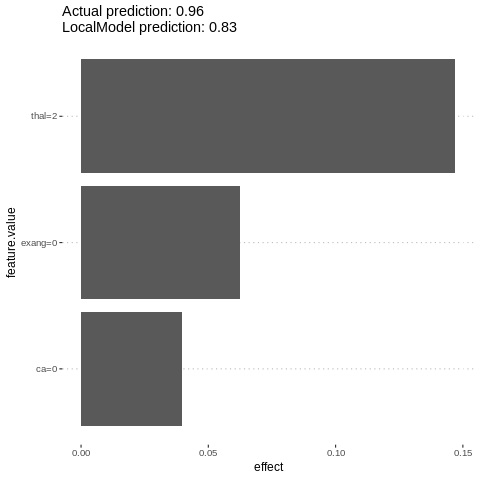

In [59]:
%%R

lime.explain = LocalModel$new(predictor.AutoML, x.interest = features[1,])

lime.explain$results


plot(lime.explain)

  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%


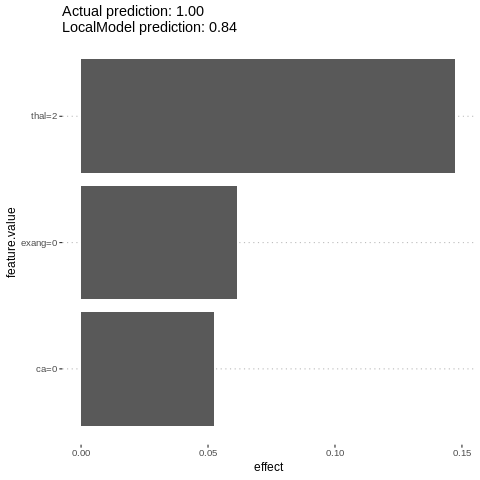

In [60]:
%%R

lime.explain$explain(features[2,])
plot(lime.explain)

#### Measure interactions
We can also measure how strongly features interact with each other. The interaction measure regards how much of the variance of f(x) is explained by the interaction. The measure is between 0 (no interaction) and 1 (= 100% of variance of f(x) due to interactions). For each feature, we measure how much they interact with any other feature:


  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |=====================================

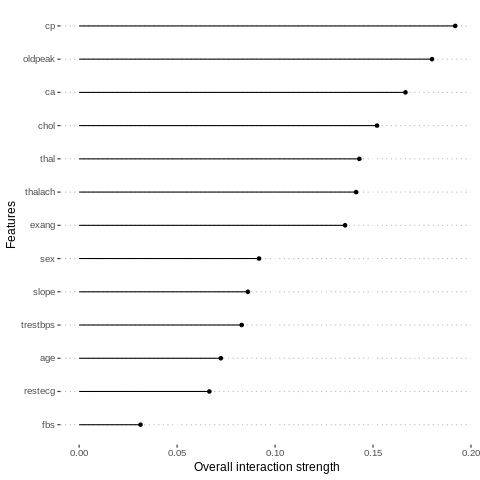

In [61]:
%%R
interact = Interaction$new(predictor.AutoML)
plot(interact)

  SHapley Additive exPlanations (SHAP) : Explain single predictions with game theory
----------------------------------------------------------------------------------------------------------
 
An alternative for explaining individual predictions is a method from coalitional game theory named Shapley value. Assume that for one data point, the feature values play a game together, in which they get the prediction as a payout. The Shapley value tells us how to fairly distribute the payout among the feature values.



  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%


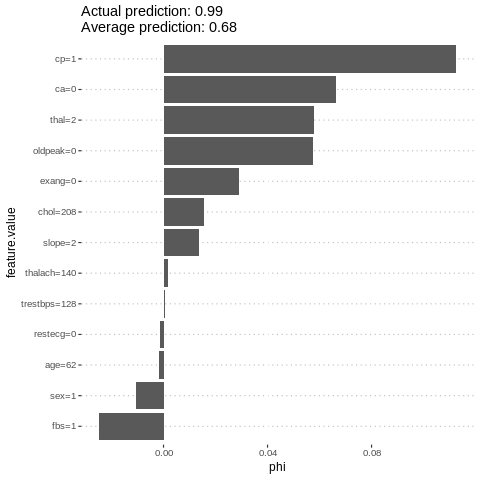

In [62]:
%%R

i=sample.int(dim(features)[1], 1)
shapley = Shapley$new(predictor.AutoML, x.interest = features[i,])
shapley$plot()

h2o

h2o Partial Dependence Plots
----------------------------------------------------------

  |======================================================================| 100%
PartialDependence: Partial Dependence Plot of model GLM_model_R_1561822704414_8033 on column 'sex'
  sex mean_response stddev_response std_error_mean_response
1   0      0.577562        0.267293                0.017702
2   1      0.527895        0.267884                0.017741


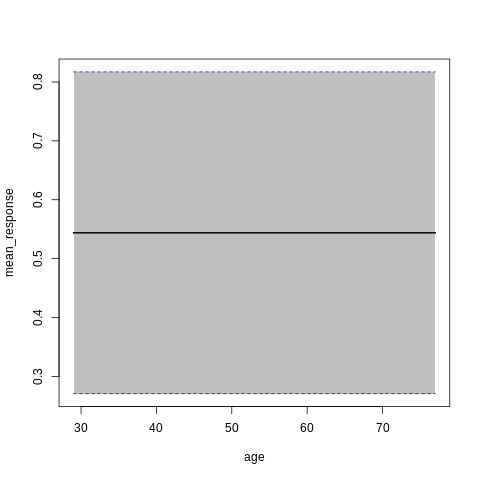

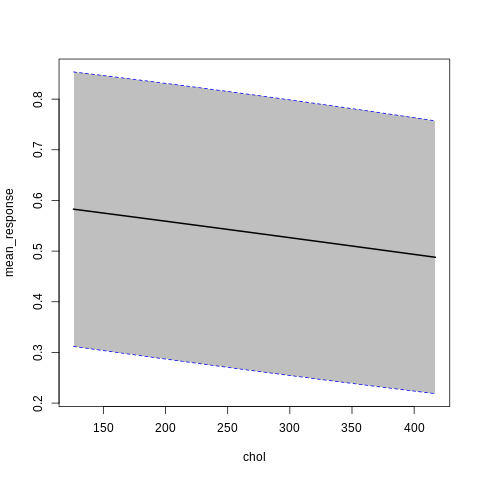

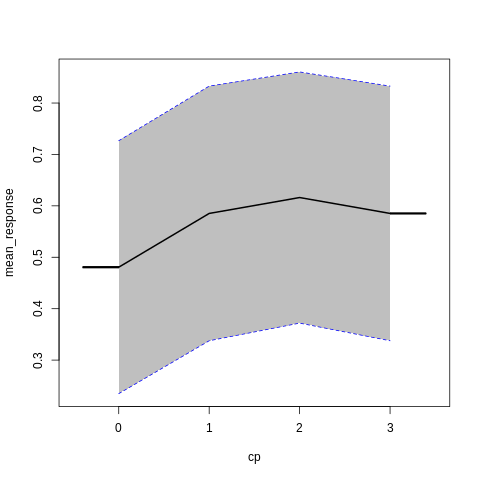

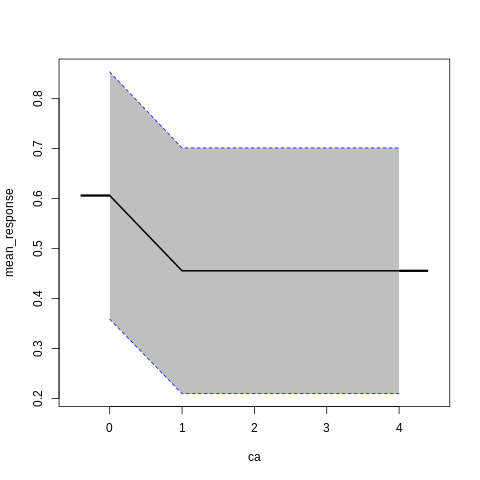

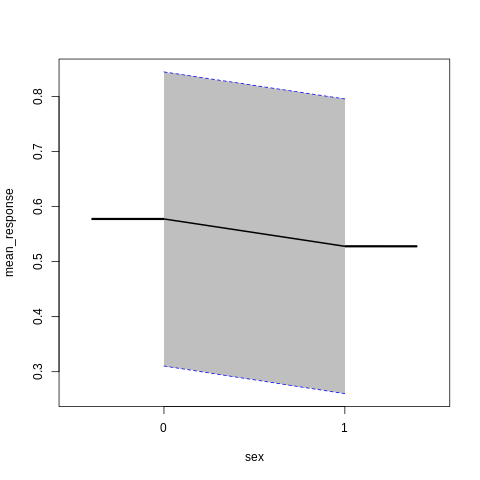

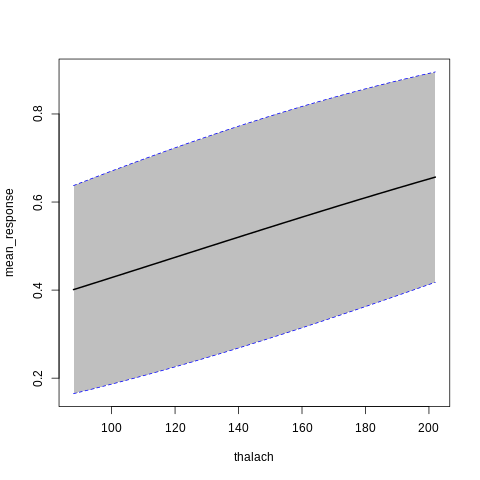

In [63]:
%%R

p7<-h2o.partialPlot(model_h2o_glm, data = train, cols = c("age","chol","cp","ca","sex","thalach"))

p7[[5]]

DALEX
----------------------------------------------------------
 

####  The explain() function

Steps to using DALEX:

* The first step of using the DALEX package is to wrap-up the black-box model with meta-data that unifies model interfacing.

* The next is to  create an explainer  function. 

In [0]:
%%R
class(train_tbl$target)

train_tbl$target<-as.numeric(train_tbl$target)

In [0]:
%%R


custom_predict <- function(model, newdata)  {
                              newdata_h2o <- as.h2o(newdata)
                              res <- as.data.frame(h2o.predict(model, newdata_h2o))
                              return(as.numeric(res$predict))
     }



explainer_h2o_glm <- DALEX::explain(model = model_h2o_glm, 
                             data = train_tbl[,-14],  
                             y = train_tbl$target,
                             predict_function = custom_predict,
                             label = "h2o glm")


explainer_h2o_automl <- DALEX::explain(model = model_h2o_automl@leader, 
                             data = train_tbl[,-14],  
                             y = train_tbl$target,
                             predict_function = custom_predict,
                             label = "h2o automl")
    
    
explainer_h2o_gbm <- explain(model = model_h2o_gbm, 
                            data = train_tbl[,-14],  
                             y = train_tbl$target,
                             predict_function = custom_predict,
                             label = "h2o gbm")    

 #### Model performance
Function model_performance() calculates predictions and residuals for validation dataset.

  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%


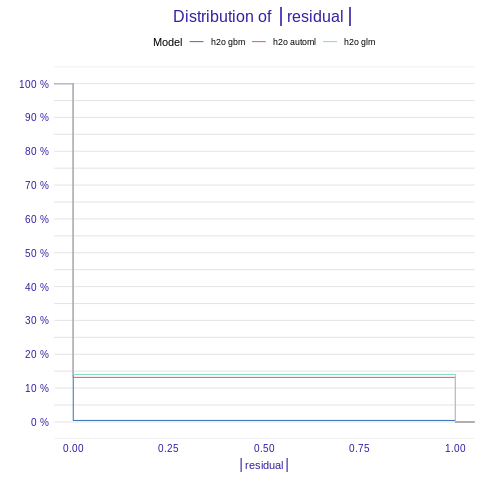

In [66]:
%%R
mp_h2o_glm <- model_performance(explainer_h2o_glm)
mp_h2o_gbm <- model_performance(explainer_h2o_gbm)
mp_h2o_automl <- model_performance(explainer_h2o_automl)

plot(mp_h2o_glm, mp_h2o_gbm, mp_h2o_automl)

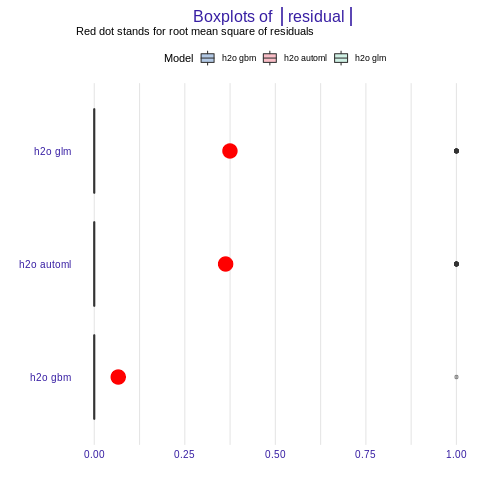

In [67]:
%%R
plot(mp_h2o_glm, mp_h2o_gbm, mp_h2o_automl, geom = "boxplot")

#### Variable importance
Using he DALEX package we are able to better understand which variables are important.

Model agnostic variable importance is calculated by means of permutations. We simply substract the loss function calculated for validation dataset with permuted values for a single variable from the loss function calculated for validation dataset.

This method is implemented in the variable_importance() function.

  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |=====================================

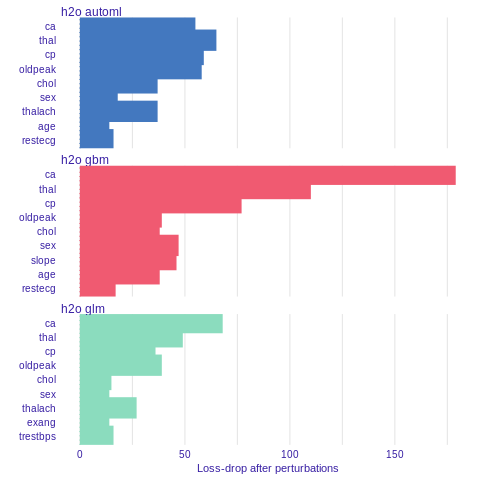

In [68]:
%%R
vi_h2o_glm <- variable_importance(explainer_h2o_glm, type="difference")
vi_h2o_gbm <- variable_importance(explainer_h2o_gbm, type="difference")
vi_h2o_automl <- variable_importance(explainer_h2o_automl, type="difference")
plot(vi_h2o_glm, vi_h2o_gbm, vi_h2o_automl)

#### Partial Dependence Plot
Partial Dependence Plots (PDP) are one of the most popular methods for exploration of the relation between a continuous variable and the model outcome.

Function variable_response() with the parameter type = "pdp" calls pdp::partial() function to calculate PDP response.

In [70]:
%%R
#install.packages("factorMerger")
#devtools::install_github("MI2DataLab/factorMerger", build_vignettes = FALSE)
#install.packages("units")
#library(units)
#library(factorMerger)
#pdp_h2o_glm <- variable_response(explainer_h2o_glm, variable = "cp")
#pdp_h2o_gbm <- variable_response(explainer_h2o_gbm, variable = "cp")
#pdp_h2o_automl <- variable_response(explainer_h2o_automl, variable = "cp")
#
#plot(pdp_h2o_glm, pdp_h2o_gbm, pdp_h2o_automl)

NULL


#### Acumulated Local Effects plot
Acumulated Local Effects (ALE) plot is the extension of PDP, that is more suited for highly correlated variables.

Function variable_response() with the parameter type = "ale" calls ALEPlot::ALEPlot() function to calculate the ALE curve for the variable construction.year.

In [73]:
%%R

#pacman::p_load(factorMerger)

#ale_h2o_glm <- variable_response(explainer_h2o_glm, variable = "ca", type = "ale")
#ale_h2o_gbm <- variable_response(explainer_h2o_gbm, variable = "ca", type = "ale")
#ale_h2o_automl <- variable_response(explainer_h2o_automl, variable = "ca", type = "ale")

#plot(ale_h2o_glm,ale_h2o_automl,ale_h2o_gbm)

NULL


 #### Merging Path Plots
Merging Path Plot is a method for exploration of a relation between a categorical variable and model outcome.

Function variable_response() with the parameter type = "factor" calls factorMerger::mergeFactors() function.

In [76]:
%%R
#library(breakDown)
#library(lime)
#library(shapleyR)


#mpp_h2o_glm <- variable_response(explainer_h2o_glm, variable = "cp", type = "factor")

#mpp_h2o_automl <- variable_response(explainer_h2o_automl, variable = "cp", type = "factor")

#mpp_h2o_gbm <- variable_response(explainer_h2o_gbm, variable = "cp", type = "factor")

#plot(mpp_h2o_glm, mpp_h2o_automl,mpp_h2o_gbm)

NULL


#### Prediction understanding
The function prediction_breakdown() is a wrapper around a breakDown package. Model prediction is visualized with Break Down Plots, which show the contribution of every variable present in the model. Function prediction_breakdown() generates variable attributions for selected prediction. The generic plot() function shows these attributions.



  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |=====================================

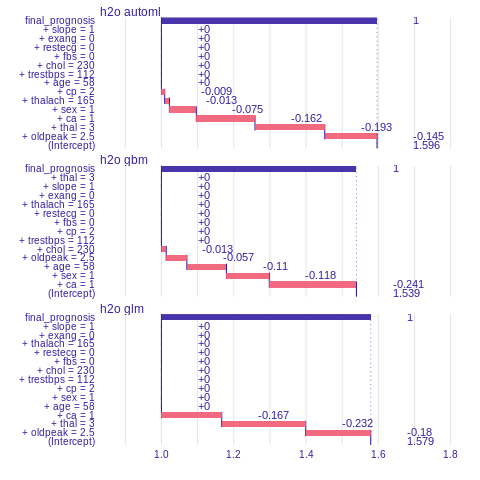

In [77]:
%%R
library("breakDown")


i=sample.int(dim(features)[1], 1)
pb_h2o_glm <- prediction_breakdown(explainer_h2o_glm, observation = as.data.frame(test[i,]))
pb_h2o_gbm <- prediction_breakdown(explainer_h2o_gbm, observation =as.data.frame(test[i,]))
pb_h2o_automl <- prediction_breakdown(explainer_h2o_automl, observation = as.data.frame(test[i,]))

plot(pb_h2o_glm, pb_h2o_gbm, pb_h2o_automl)

#### Variable importance
Using he DALEX package we are able to better understand which variables are important.

Model agnostic variable importance is calculated by means of permutations. We simply substract the loss function calculated for validation dataset with permuted values for a single variable from the loss function calculated for validation dataset.

This method is implemented in the variable_importance() function.

  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |=====================================

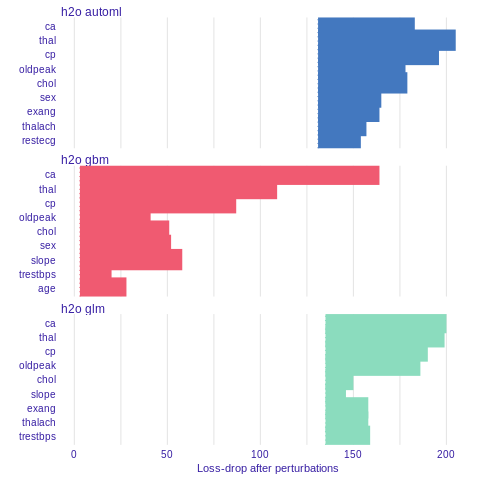

In [78]:
%%R

vi_h2o_glm <- variable_importance(explainer_h2o_glm)

vi_h2o_gbm <- variable_importance(explainer_h2o_gbm)

vi_h2o_automl <- variable_importance(explainer_h2o_automl)

#We can compare all models using the generic plot() function.

plot(vi_h2o_glm, vi_h2o_gbm, vi_h2o_automl)

#### Model performance
Function model_performance() calculates predictions and residuals for validation dataset


In [79]:
%%R

#data(apartments)
#head(apartments)


train_hf <- as.h2o(train_tbl)

model_h2o_glm <- h2o.glm(y = "target", training_frame = train_hf, family = "binomial")
model_h2o_gbm <- h2o.gbm(y = "target", training_frame = train_hf)
model_h2o_automl <- h2o.automl(y = "target", training_frame = train_hf, max_models = 10)


custom_predict <- function(model, newdata)  {
                              newdata_h2o <- as.h2o(newdata)
                              res <- as.data.frame(h2o.predict(model, newdata_h2o))
                              return(as.numeric(res$predict))
     }

explainer_h2o_glm <- explain(model = model_h2o_glm, 
                             data = test_tbl[,-14],  
                             y = test_tbl$target,
                             predict_function = custom_predict,
                             label = "h2o glm")

explainer_h2o_gbm <- explain(model = model_h2o_gbm, 
                             data = test_tbl[,-14],  
                             y = test_tbl$target,
                             predict_function = custom_predict,
                             label = "h2o gbm")

explainer_h2o_automl <- explain(model = model_h2o_automl, 
                             data = test_tbl[,-14],  
                             y = test_tbl$target,
                             predict_function = custom_predict,
                             label = "h2o automl")

mp_h2o_glm <- model_performance(explainer_h2o_glm)
mp_h2o_gbm <- model_performance(explainer_h2o_gbm)
mp_h2o_automl <- model_performance(explainer_h2o_automl)
#Generic function print() returns quantiles for residuals.

mp_h2o_glm

plot(mp_h2o_glm, mp_h2o_gbm, mp_h2o_automl)

  |======================================================================| 100%

ERROR: Unexpected HTTP Status code: 412 Precondition Failed (url = http://localhost:54321/3/ModelBuilders/glm)

water.exceptions.H2OModelBuilderIllegalArgumentException
 [1] "water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for GLM model: GLM_model_R_1561822704414_8144.  Details: ERRR on field: _family: Binomial requires the response to be a 2-class categorical or a binary column (0/1)\n\nFor more information visit:\n  http://jira.h2o.ai/browse/TN-2\n"
 [2] "    water.exceptions.H2OModelBuilderIllegalArgumentException.makeFromBuilder(H2OModelBuilderIllegalArgumentException.java:20)"                                                                                                                                                                                        
 [3] "    hex.ModelBuilder.trainModelOnH2ONode(ModelBuilder.java:272)"                                              

/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Error in .h2o.doSafeREST(h2oRestApiVersion = h2oRestApiVersion, urlSuffix = page,  : 
  

ERROR MESSAGE:

Illegal argument(s) for GLM model: GLM_model_R_1561822704414_8144.  Details: ERRR on field: _family: Binomial requires the response to be a 2-class categorical or a binary column (0/1)

For more information visit:
  http://jira.h2o.ai/browse/TN-2



  warnings.warn(x, RRuntimeWarning)


In [80]:
%%R

pdp_h2o_glm <- DALEX::variable_response(explainer_h2o_glm,type = "pdp", variable = "ca")
pdp_h2o_gbm <- DALEX::variable_response(explainer_h2o_gbm,type = "pdp", variable = "ca")
pdp_h2o_automl <- DALEX::variable_response(explainer_h2o_automl,type = "pdp", variable = "ca")

plot(pdp_h2o_glm, pdp_h2o_gbm, pdp_h2o_automl)

  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
Error in loadNamespace(name) : there is no package called ‘factorMerger’


In [0]:
%%R

summary(explainer_glm)

#### shapper

Install the Python library shap
Before you run shapper, make sure that you have installed Python.

Python library shap is required to use shapper. The shap can be installed both by Python or R. To install it through R, you an use function install_shap() from the shapper package.



In [0]:
!sudo apt-get install python-virtualenv

Reading package lists... Done
Building dependency tree       
Reading state information... Done
python-virtualenv is already the newest version (15.1.0+ds-1.1).
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 11 not upgraded.


In [0]:
%%R
install.packages("shapper")
library("shapper")
library(reticulate)
install_shap()
reticulate::py_install(c("numpy", "pandas"))


/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'https://cran.rstudio.com/src/contrib/shapper_0.1.0.tar.gz'

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Content type 'application/x-gzip'
  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 20592 bytes (20 KB)

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: =
  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/dis

Using virtual environment 'r-reticulate' ...
Error: Error installing package(s): 'pip'


/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 
  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: The downloaded source packages are in
	‘/tmp/Rtmp2EwiDK/downloaded_packages’
  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Error: Error installing package(s): 'pip'

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: In addition: 
  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Warning message:

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: In system2(pip, args) :
  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: R

In [0]:
%%R 

library(shapper)


p_function <- function(model, data) {
    

p=predict(model,data)[,-1]  
    
prob=apply(p,1,max)    
    
return(prob)    
}

#predict(model, newdata = data, type = "prob")

#p_function(model_h2o_automl@leader,test)



#p_function <- function(model, data) predict(model, newdata = data, type = "prob")

ive_rf <- individual_variable_effect(model_h2o_automl@leader, data = train, predict_function = p_function,
            new_observation = train[1:2,], nsamples = 50)

# plot
plot(ive_rf)

In [0]:

#### iBreakDown plots for classification models

https://cran.r-project.org/web/packages/iBreakDown/vignettes/vignette_iBreakDown_classification.html

In [0]:
# devtools::install_github("ModelOriented/DALEX")
library("DALEX")
library("iBreakDown")

head(HR)
new_observation <- HR_test[1,]
new_observation

library("nnet")
m_glm <- multinom(status ~ . , data = HR, probabilities = TRUE, model = TRUE)

p_fun <- function(object, newdata) {
   if (nrow(newdata) == 1) {
      as.matrix(t(predict(object, newdata, type = "prob")))
   } else {
     as.matrix(predict(object, newdata=newdata, type = "prob"))
   }
 }

bd_glm <- local_attributions(m_glm,
                            data = HR_test,
                            new_observation =  new_observation,
                            keep_distributions = TRUE,
                            predict_function = p_fun)




bd_glm

In [0]:
plot(bd_glm)

Use the baseline argument to set the origin of plots.

plot(bd_glm, baseline = 0)

#Use the plot_distributions argument to see distributions of partial predictions.

plot(bd_glm, plot_distributions = TRUE)

#### Explaining classification models with localModel package

In [0]:
library(DALEX)
library(randomForest)
library(localModel)

data('HR')

set.seed(17)
mrf <- randomForest(status ~., data = HR, ntree = 100)
explainer <- explain(mrf, 
                     HR[, -6],
                     predict_function = function(x, y) predict(x, y, type = "prob"))
new_observation <- HR[10, -6]
new_observation


model_lok <- individual_surrogate_model(explainer, new_observation, 
                                        size = 500, seed = 17)
plot(model_lok)

In [98]:
%%R
h2o.shutdown(prompt = TRUE)

Are you sure you want to shutdown the H2O instance running at http://localhost:54321/ (Y/N)? Y


[1] TRUE
